In [1]:
# dataFolder = "../data/ATT"
# pathName = "ECMP"
dataFolder = "ATT"
pathName = "SMORE"


In [2]:
"""
parse topology file
input: topology file
output: [( node1, node2, {'capacity': capacity}),] 
"""
def parseTopology(topology_path):
    topologyFile = open(topology_path)
    count = 0
    edgeList = []
    for line in topologyFile:
        count += 1
        if count == 1:
            continue
        linelist = line.split()
        edgeList.append((int(linelist[0]), int(linelist[1]), {'capacity': int(linelist[2])}))
        # print(linelist)
    return edgeList
           
topology_path = dataFolder + "/topology.txt"       
edgeList = parseTopology(topology_path)
# print(edgeList)

In [3]:
"""
extract nodelist from nodes.txt
input: node file path
output: list of node (int)

"""
def extractNodes(nodefile):
    nodeFile = open(nodefile)
    count = 0
    nodeList = []
    for line in nodeFile:
        count += 1
        if count == 1:
            continue
        node = line.strip()[1:]
        nodeList.append(int(node))
        #print (line)
    return nodeList

nodefile = dataFolder + "/nodes.txt"
nodeList = extractNodes(nodefile)
# print(nodeList)

In [4]:
"""
construct graph

"""
# add node
import networkx as nx
DG = nx.DiGraph()
DG.add_nodes_from(nodeList)
# add edge
DG.add_edges_from(edgeList)
# print(DG)

# get edges: return a list of edges(tuple)
# DG.edges()

In [5]:
"""
capacitys: 
{(node1, node2): capacity, }
"""
capacitys = nx.get_edge_attributes(DG,'capacity')
# print(capacitys)

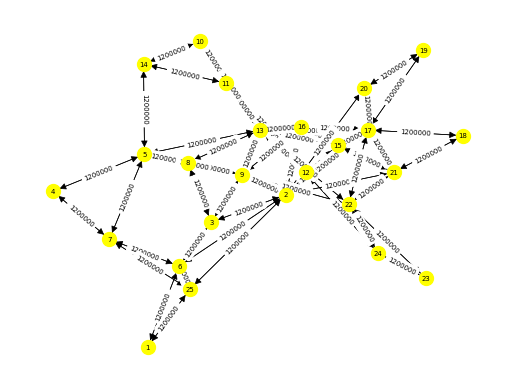

In [6]:
"""
draw graph
first draw nodes and edges, then add capacity to the edge
"""

import matplotlib.pyplot as plt
pos=nx.spring_layout(DG)
# print(pos)
plt.figure()
# draw nodes
nx.draw_networkx(DG, pos, with_labels=True,node_color='yellow', font_size = 5,node_size=100, width=0.5, linewidths=1)
# draw capacities
nx.draw_networkx_edge_labels(DG, pos, edge_labels=capacitys, font_size=5)
plt.axis('off')
plt.show()

In [7]:
"""  
parse the demand.txt
input: demand file path
output: max_demand_matrix
        max_demand_matrix[x][y] means max demand from node x to node y
        {
            1:{ 1:float, 2:float, 3:,..., 25:float}
            2:
            3:
            ..
            25:
        }
"""

def parseDemand(demandFile): 
    demandFile = open(demandFile)
    demand_matrix = {}
    max_demand_matrix = {}
    node_amount = len(nodeList)

    # extract the demand list from x to y
    for line in demandFile:
        row = [float(x) for x in line.split()]
        for index, demand in enumerate(row):
            from_node = int(index/node_amount) + 1
            to_node = index%node_amount +1
            if from_node not in demand_matrix:
                demand_matrix[from_node] = {}
                max_demand_matrix[from_node] = {}
            if to_node not in demand_matrix[from_node]:
                demand_matrix[from_node][to_node] = []
            demand_matrix[from_node][to_node].append(demand)
    
    # just want to max demand from x to y
    for from_node in demand_matrix:
        for to_node in demand_matrix:
            max_demand = max(demand_matrix[from_node][to_node])
            max_demand_matrix[from_node][to_node] = max_demand
    return max_demand_matrix


demandFile = dataFolder + "/demand.txt"
max_demand_matrix = parseDemand(demandFile)
# print(max_demand_matrix)


In [8]:
"""
parse the path file
input: path file path
output: list of all path
"""
def extractAllPaths(pathFile): 
    pathFile = open(pathFile)
    pathCollection = []
    for line in pathFile:
        line = line.strip()
        if len(line) == 0: continue
        if line[0] == "h": continue
        line = line.split("@")[0]
        path = []
        p = 0
        while p < len(line):
            if line[p] == "s":
                # print(line[p])
                node_str = ""
                p += 1
                # print(line[p])
                while line[p].isdigit():
                    # print(line[p])
                    node_str += line[p]
                    p += 1

                if path and path[-1] == int(node_str):
                    pass
                else:
                    path.append(int(node_str))
            p += 1
        # print(path)
        edgesInPath = []
        for i in range(1, len(path)):
            edgesInPath.append((path[i-1], path[i]))
        pathCollection.append(edgesInPath)
    return pathCollection

pathFile = dataFolder + "/paths/" + pathName
pathCollection = extractAllPaths(pathFile)
# print(pathCollection)

In [9]:
""" 
find shortest path (the path contain least edges) for every (source, destination)
input: pathCollection: list of all path
output: {(source_node, destination_node): [edges]}
        for example: {(10, 19):[(10, 13), (13, 17), (17, 19)], }

"""
def findShortestPath(pathCollection):
    shortestPathDic = {}
    for path in pathCollection:
        key = (path[0][0], path[len(path)-1][1])
        if key not in shortestPathDic:
            shortestPathDic[key] = path
        else:
            if len(path) < len(shortestPathDic[key]):
                shortestPathDic[key] = path
    return shortestPathDic

shortestPathDic = findShortestPath(pathCollection)
# check output
# for item in shortestPathDic.items():
#     print(item)


In [10]:
""" 
find all paths that an edge belongs to
input: shortestPathDic: {(source_node, destination_node): [edges]}
output: edges_belongsto_paths: {(node1, node2): [(s1, d1), (s2, d2),], }
for example:
  {(8, 5): [(8, 7), (8, 4), (8, 5), (8, 14), (3, 5), (3, 14), }
"""

def findEdgesBelongs(shortestPathDic):
    edges_belongsto_paths = {}
    for path, edgeList in shortestPathDic.items():
        for edge in edgeList:
            if edge not in edges_belongsto_paths:
                edges_belongsto_paths[edge] = [path]
            else:
                edges_belongsto_paths[edge].append(path)
    return edges_belongsto_paths

edges_belongsto_paths = findEdgesBelongs(shortestPathDic)
# check output:
# for item in edges_belongsto_paths.items():
#     print(item)

In [11]:
""" 
find path and its max demand
input: shortestPathDic, use the path
output: {(source, destination): int(demand)}
"""
def findPathDemand(shortestPathDic):
    path_demands_dic = {}
    for path in shortestPathDic:
        path_demands_dic[path] = int(max_demand_matrix[path[0]][path[1]])
    return path_demands_dic

path_demands_dic = findPathDemand(shortestPathDic)
# check output:
# for item in path_demands_dic.items():
#     print(item)

In [12]:

import gurobipy as gp
from gurobipy import GRB
import time

start_time = time.time()

# path,demands = gp.multidict({
#     (1,2):100,
#     (2,3):200,
#     (1,3):300})
path,demands = gp.multidict(path_demands_dic)

# edge: all path (s, d) contains edge
# edges = {
#     (1,2):[(1,2),(1,3)],
#     (2,3):[(2,3),(1,3)]}
edges = edges_belongsto_paths

# {(node1, node2): capacity}
# capacity = {
#     (1,2):400,
#     (2,3):500}
capacity = capacitys

m = gp.Model('te')

#create variable
flow = m.addVars(path,name = "flow")

#set objective
m.setObjective(flow.sum('*'),GRB.MAXIMIZE)

#add constraint: sum of flow on each edge <= capcity
for edge_key,edge_value in edges.items():
    m.addConstr( sum(flow[p] for p in edge_value) <= capacity[edge_key],"cap")
    
#add constraint: flow[p] <= demand
m.addConstrs((flow[p]<= demands[p] for p in path),"dem")

m.optimize()

if m.Status == GRB.OPTIMAL:
    solution = m.getAttr('X',flow)
    # check output
    for f in path:
        print(solution[f])

print("The run time is --- %s seconds ---" % (time.time() - start_time))

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1280P, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 712 rows, 600 columns and 2034 nonzeros
Model fingerprint: 0x9f4ea5cc
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+06]
Presolve removed 702 rows and 572 columns
Presolve time: 0.01s
Presolved: 10 rows, 28 columns, 54 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8436378e+07   2.433599e+05   0.000000e+00      0s
      12    1.8053174e+07   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.805317400e+07
1434.0
2103.0
10685.0
6890.0
3590.0
5854.0
4507.0
2779.0
1973.0
7

In [13]:
#visualization flow allocation
vis_edge = {}
for edge_key,edge_value in edges.items():
    sum = 0
    for p in edge_value:
        sum += solution[p]
    vis_edge[edge_key]= int(sum/1000)
print(vis_edge)

{(8, 9): 1, (8, 3): 783, (3, 2): 7, (3, 6): 191, (6, 25): 121, (6, 1): 461, (8, 5): 9, (5, 7): 828, (5, 4): 173, (8, 13): 348, (13, 22): 455, (22, 23): 58, (13, 17): 953, (17, 21): 175, (17, 20): 579, (17, 19): 72, (17, 18): 423, (13, 12): 1200, (13, 11): 1096, (13, 10): 429, (13, 16): 796, (13, 15): 239, (5, 14): 1200, (22, 24): 1200, (9, 8): 23, (9, 2): 184, (9, 3): 86, (2, 25): 442, (2, 6): 789, (9, 5): 45, (9, 22): 144, (2, 21): 419, (2, 20): 362, (20, 19): 72, (2, 17): 328, (9, 13): 135, (9, 16): 103, (2, 15): 240, (2, 3): 819, (3, 8): 698, (2, 9): 72, (6, 7): 881, (7, 4): 162, (17, 22): 564, (17, 13): 1200, (2, 16): 575, (3, 9): 62, (25, 6): 16, (6, 3): 747, (25, 2): 92, (25, 1): 20, (25, 7): 7, (7, 5): 514, (16, 13): 532, (1, 6): 264, (6, 2): 1200, (1, 25): 16, (5, 8): 747, (5, 9): 123, (7, 6): 691, (7, 25): 280, (5, 13): 1200, (4, 5): 18, (4, 7): 96, (22, 21): 289, (12, 24): 592, (23, 22): 160, (22, 13): 268, (13, 8): 676, (22, 9): 147, (22, 17): 188, (17, 2): 631, (13, 5): 231

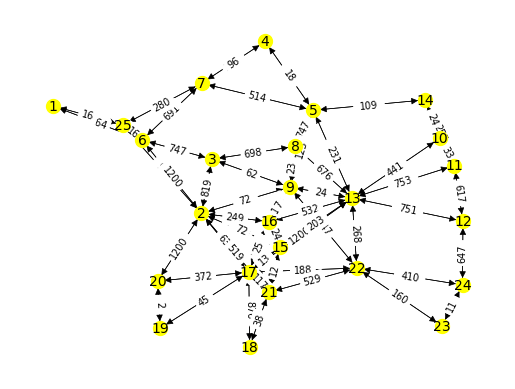

In [14]:
import matplotlib.pyplot as plt
pos=nx.spring_layout(DG)
# print(pos)
plt.figure()
# draw nodes
nx.draw_networkx(DG, pos, with_labels=True,node_color='yellow', font_size = 10,node_size=100, width=0.5, linewidths=1)
# draw capacities
nx.draw_networkx_edge_labels(DG, pos, edge_labels=vis_edge, font_size=7)
plt.axis('off')
plt.show()